In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV, learning_curve, KFold 
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Data Load and preprocess

In [2]:
data_name = "./online_shoppers_intention.csv"

df = pd.read_csv(data_name)

# print("Shape: {}".format(df.shape))
# print("Sample: {}".format(df.head()))


In [3]:
df.isnull().values.any()

False

In [4]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


/Users/zj88zj/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


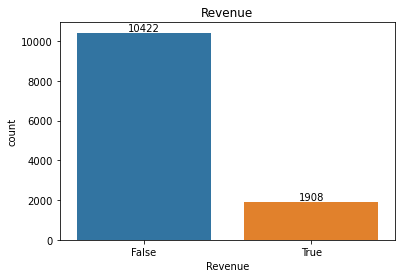

In [5]:
ax = sns.countplot('Revenue',data=df)
ax.bar_label(ax.containers[0])
plt.title('Revenue')
plt.savefig('./Revenue_freq.png')
plt.show()

In [6]:
nums,cats = df.select_dtypes(include=np.number), df.select_dtypes(exclude=np.number)
nums_t = pd.DataFrame(PowerTransformer().fit_transform(nums),columns=nums.columns)
alls = pd.concat([nums_t,cats],axis=1)
alls['Weekend'].replace({False:0,True:1},inplace =True)
alls['Revenue'].replace({'No':0,'Yes':1},inplace =True)
alls = pd.get_dummies(alls,drop_first=True)

In [7]:
X = alls.iloc[:, :-1]
y = alls.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# y_test.shape

# For Model Compare

In [8]:
train_times = pd.DataFrame()
train_times['Model'] = ['DT','Boost','NN','SVM','KNN']
f1scores = []
accuracies = []
bias_errors = []
variance_errors = []
Train_times = []
Test_times = []

# Evaluation Function

In [9]:
def Evaluation_basic(model,X_train, X_test, y_train, y_test):
    
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()
    train_time = t1 - t0
     
    t0 = time.time()   
    y_pred = model.predict(X_test)
    t1 = time.time()
    pred_time = t1 - t0
    
    auc = roc_auc_score(y_test, y_pred)
    bias_error = np.mean(1-auc)
    variance_error = np.std(auc,ddof=1)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    
    # confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(pd.DataFrame(cm),annot=True,fmt='d',cbar=False, cmap="YlGnBu")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('./confusion_matrix.png')
    plt.show()
    
    # roc
    plot_roc_curve(dt,X_train,y_train)
    plt.title('Testing')
    plt.savefig('./ROC_test.png')
    plt.show()
    
    return train_time, pred_time, f1, accuracy, bias_error, variance_error

def Visualize_LC(model, X_train, y_train):
    
    sizes = np.linspace(0.1, 1.0, 20)
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train,train_sizes =sizes, scoring='f1', cv=5)
    
    trains = np.mean(train_scores, axis=1)
    valids = np.mean(test_scores, axis=1)
            
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel("F1 Score")
    plt.plot(train_sizes, trains, 'o-', label="Training Score")
    plt.plot(train_sizes, valids, 'o-', label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.savefig('learning_curve.png')
    plt.show()
    

# Decision tree

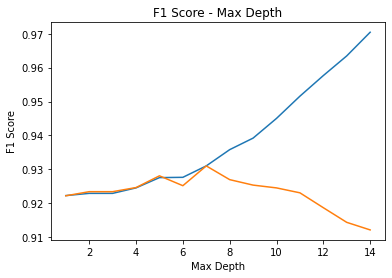

Criterion Used: gini
Best Max Tree Depth: 7


/Users/zj88zj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


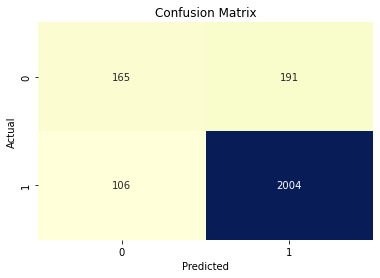

/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


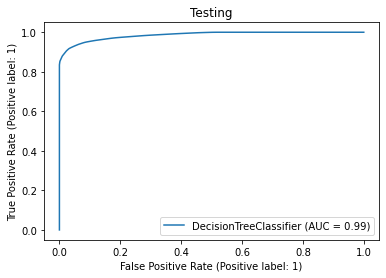

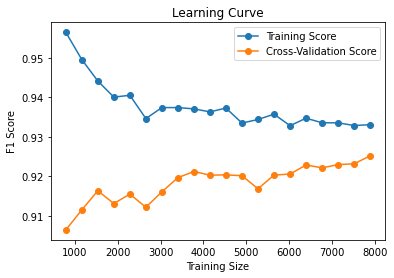

Decision tree traning time: 0.19867706298828125
Decision tree testing time: 0.0598452091217041
Decision tree F1: 0.9310104529616725
Decision tree Accuracy: 0.8795620437956204


In [10]:
max_depth = list(range(1,15))
f_test = []
f_train = []

for i in max_depth:         
    dt = DecisionTreeClassifier(max_depth=i, random_state=0, min_samples_leaf=1, criterion='entropy')
    dt.fit(X_train, y_train)
    y_pred_test = dt.predict(X_test)
    y_pred_train = dt.predict(X_train)
    
    f_test.append(f1_score(y_test, y_pred_test))
    f_train.append(f1_score(y_train, y_pred_train))

plt.plot(max_depth, f_train, label='Training')
plt.plot(max_depth, f_test, label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('Max Depth')
plt.title("F1 Score - Max Depth")
plt.savefig('./f1-mxDepth.png')
plt.show()


params = {'max_depth':np.arange(1,10),'criterion':['gini','entropy']}
gsv = GridSearchCV(dt,params,cv=5,scoring='roc_auc')
gsv.fit(X_train,y_train)
best_parms = gsv.best_params_
print("Criterion Used:", gsv.best_params_['criterion'])
print("Best Max Tree Depth:", gsv.best_params_['max_depth'])

DT = DecisionTreeClassifier(max_depth=best_parms['max_depth'],criterion='entropy',random_state=0)
train_time, pred_time, f1, accuracy, bias_error, variance_error= Evaluation_basic(DT,X_train, X_test, y_train, y_test)
Visualize_LC(DT, X_train, y_train)
print("Decision tree traning time:", train_time)
print("Decision tree testing time:",pred_time)
print("Decision tree F1:",f1)
print("Decision tree Accuracy:",accuracy)

accuracies.append(('DT', accuracy))
f1scores.append(('DT', f1))
Train_times.append(('DT',train_time))
Test_times.append(('DT',pred_time))
bias_errors.append(('DT', bias_error))
variance_errors.append(('DT', variance_error))

# Neural Network

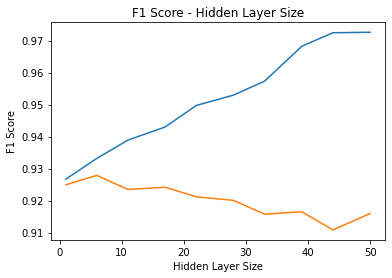

In [11]:
f_test = []
f_train = []
units = np.linspace(1,50,10).astype('int')
for i in units:         
    nn = MLPClassifier(hidden_layer_sizes=(i,), learning_rate_init=0.01, solver='adam', activation='logistic', random_state=0, max_iter=800)
    nn.fit(X_train, y_train)
    y_pred_train = nn.predict(X_train)
    y_pred_test = nn.predict(X_test)
    f_train.append(f1_score(y_train, y_pred_train))
    f_test.append(f1_score(y_test, y_pred_test))

plt.plot(units, f_train, label='Training')
plt.plot(units, f_test, label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('Hidden Layer Size')
plt.title("F1 Score - Hidden Layer Size")
plt.savefig('./f1-NNunit.png')
plt.show()

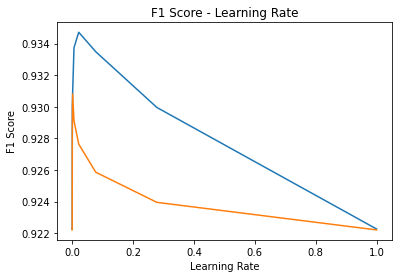

In [12]:
f_test = []
f_train = []
lrs = np.logspace(-5, 0, 10)
for i in lrs:         
    nn = MLPClassifier(hidden_layer_sizes=(5,), learning_rate_init=i, solver='adam', activation='logistic', random_state=0, max_iter=800)
    nn.fit(X_train, y_train)
    y_pred_train = nn.predict(X_train)
    y_pred_test = nn.predict(X_test)
    f_train.append(f1_score(y_train, y_pred_train))
    f_test.append(f1_score(y_test, y_pred_test))

plt.plot(lrs, f_train, label='Training')
plt.plot(lrs, f_test, label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('Learning Rate')
plt.title("F1 Score - Learning Rate")
plt.savefig('./f1-NNlr.png')
plt.show()

In [13]:
hidden_sizes = [2, 5, 8, 10]
learning_rates = [0.001, 0.01, 0.1]
param_grid = {'hidden_layer_sizes': hidden_sizes, 'learning_rate_init': learning_rates}
nn = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic', random_state=0, max_iter=1000), param_grid=param_grid, cv=5)
nn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=1000,
                                     random_state=0),
             param_grid={'hidden_layer_sizes': [2, 5, 8, 10],
                         'learning_rate_init': [0.001, 0.01, 0.1]})

In [14]:
print("Best hidden size",nn.best_params_['hidden_layer_sizes'])
print("Best learning rate",nn.best_params_['learning_rate_init'])

hs = nn.best_params_['hidden_layer_sizes']
lr = nn.best_params_['learning_rate_init']

Best hidden size 10
Best learning rate 0.001


/Users/zj88zj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


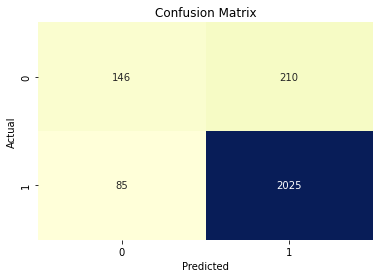

/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


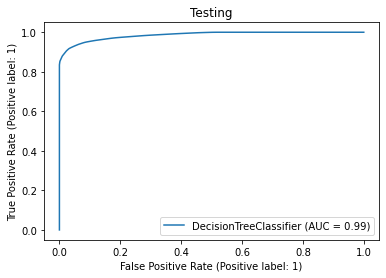

Neural network traning time: 10.078094959259033
Neural network testing time: 0.009782075881958008
Neural network F1: 0.9321058688147297
Neural network Accuracy: 0.8803730738037308


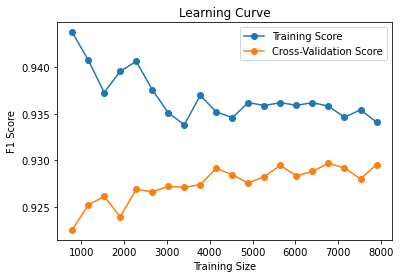

In [15]:
NN = MLPClassifier(hidden_layer_sizes=(hs,),solver='adam',activation='logistic',learning_rate_init=lr,random_state=0,max_iter=1000)
train_time, pred_time, f1, accuracy, bias_error, variance_error= Evaluation_basic(NN,X_train, X_test, y_train, y_test)
print("Neural network traning time:", train_time)
print("Neural network testing time:",pred_time)
print("Neural network F1:",f1)
print("Neural network Accuracy:",accuracy)

f1scores.append(('NN', f1))
accuracies.append(('NN', accuracy))
Train_times.append(('NN',train_time))
Test_times.append(('NN',pred_time))
bias_errors.append(('NN', bias_error))
variance_errors.append(('NN', variance_error))

Visualize_LC(NN, X_train, y_train)

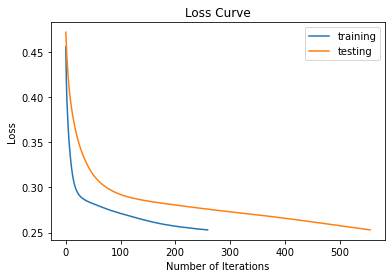

In [16]:
NN.fit(X_train, y_train)
train_loss = NN.loss_curve_
NN.fit(X_test, y_test)
test_loss = NN.loss_curve_

plt.figure()
plt.title("Loss Curve")
plt.plot(train_loss, label="training")
plt.plot(test_loss, label="testing")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.savefig('./NNloss.png')
plt.show()

# Boosting

In [21]:
learning_rates = [0.001, 0.01, 0.1]
params = {'n_estimators': np.linspace(10,100,4).astype('int'),'learning_rate': learning_rates}
bst = GridSearchCV(estimator = AdaBoostClassifier(base_estimator = DT), param_grid=params, cv=5)
bst.fit(X_train, y_train)

print("Best number of estimators",bst.best_params_['n_estimators'])
print("Best learning rate",bst.best_params_['learning_rate'])

lr = bst.best_params_['learning_rate']
n = bst.best_params_['n_estimators']

Best number of estimators 40
Best learning rate 0.01


/Users/zj88zj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


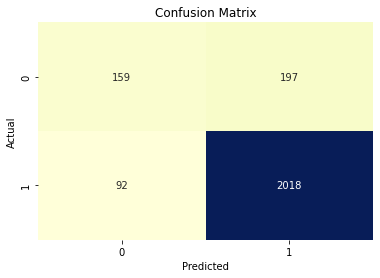

/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


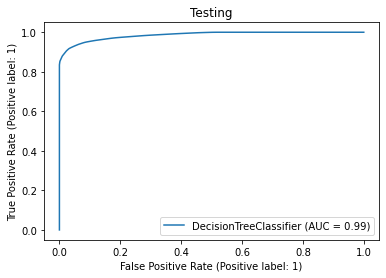

Boost traning time: 3.6511991024017334
Boost testing time: 0.16058993339538574
Boost F1: 0.9331791907514452
Boost Accuracy: 0.8828061638280617


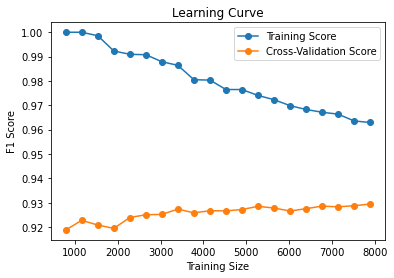

In [22]:
Boost = AdaBoostClassifier(base_estimator = DT, n_estimators=n, learning_rate = lr, random_state=0)
train_time, pred_time, f1, accuracy, bias_error, variance_error= Evaluation_basic(Boost,X_train, X_test, y_train, y_test)
print("Boost traning time:", train_time)
print("Boost testing time:",pred_time)
print("Boost F1:",f1)
print("Boost Accuracy:",accuracy)

f1scores.append(('Boost', f1))
accuracies.append(('Boost', accuracy))
Train_times.append(('Boost',train_time))
Test_times.append(('Boost',pred_time))
bias_errors.append(('Boost', bias_error))
variance_errors.append(('Boost', variance_error))

Visualize_LC(Boost, X_train, y_train)

# SVM

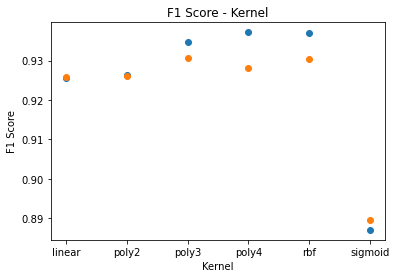

In [26]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [2,3,4]
f_test = []
f_train = []
for k in kernels:
    if k == 'poly':
        for i in degrees:
            svm = SVC(kernel=k, degree=i,random_state=0)
            svm.fit(X_train, y_train)
            y_pred_train = svm.predict(X_train)
            y_pred_test = svm.predict(X_test)
            f_train.append(f1_score(y_train, y_pred_train))
            f_test.append(f1_score(y_test, y_pred_test))
            
    else:
        svm = SVC(kernel=k, random_state=0)
        svm.fit(X_train, y_train)
        y_pred_train = svm.predict(X_train)
        y_pred_test = svm.predict(X_test)
        f_train.append(f1_score(y_train, y_pred_train))
        f_test.append(f1_score(y_test, y_pred_test))
        
plt.plot(['linear','poly2','poly3','poly4','rbf','sigmoid'], f_train, 'o', label='Training')
plt.plot(['linear','poly2','poly3','poly4','rbf','sigmoid'], f_test, 'o', label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('Kernel')
plt.title("F1 Score - Kernel")
plt.savefig('./f1-SVMkernel.png')
plt.show()

In [40]:
Cs = [0.01, 0.1, 1, 10]
svm = GridSearchCV(estimator = SVC(kernel='rbf',random_state=0),param_grid={'C': Cs}, cv=5)
svm.fit(X_train, y_train)

C = svm.best_params_['C']

In [42]:
print("Best C",svm.best_params_['C'])

Best C 10


/Users/zj88zj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


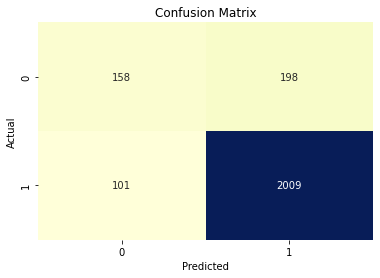

/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


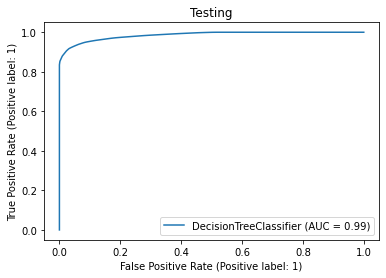

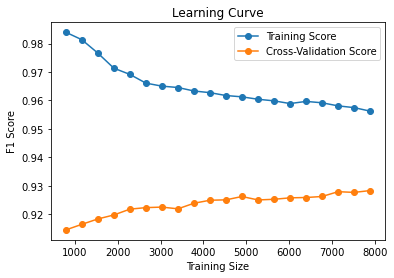

SVM traning time: 5.013474225997925
SVM testing time: 1.571958065032959
SVM F1: 0.9307389390780634
SVM Accuracy: 0.8787510137875101


In [43]:
SVM = SVC(kernel='rbf',C=C, random_state=0)
train_time, pred_time, f1, accuracy, bias_error, variance_error= Evaluation_basic(SVM,X_train, X_test, y_train, y_test)
Visualize_LC(SVM, X_train, y_train)

print("SVM traning time:", train_time)
print("SVM testing time:",pred_time)
print("SVM F1:",f1)
print("SVM Accuracy:",accuracy)

f1scores.append(('SVM', f1))
accuracies.append(('SVM', accuracy))
Train_times.append(('SVM',train_time))
Test_times.append(('SVM',pred_time))
bias_errors.append(('SVM', bias_error))
variance_errors.append(('SVM', variance_error))

# kNN

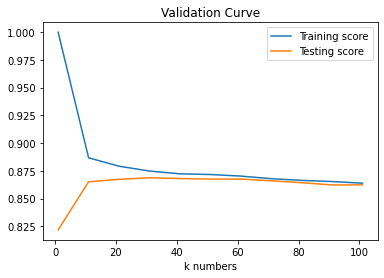

In [50]:
ks = np.arange(1,110,10)
train_scores, test_scores = validation_curve(KNeighborsClassifier(n_jobs=-1), X_train, y_train, param_name="n_neighbors",param_range=ks, cv=5)

plt.figure()
plt.plot(ks, np.mean(train_scores, axis=1), label='Training score')
plt.plot(ks, np.mean(test_scores, axis=1), label='Testing score')
plt.xlabel('k numbers')
plt.ylabel("")
plt.title('Validation Curve')
plt.legend(loc="best")
plt.savefig('./knn_k.png')
plt.show()

In [51]:
# kf = KFold(n_splits=4,shuffle=True, random_state=0)
knn = GridSearchCV(KNeighborsClassifier(),{'n_neighbors':np.arange(20,60)},cv=5)
knn.fit(X_train,y_train)
k = knn.best_params_['n_neighbors']
print("Best k number:",k)

Best k number: 48


/Users/zj88zj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


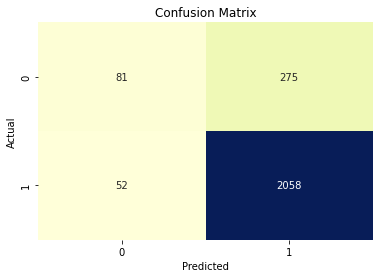

/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


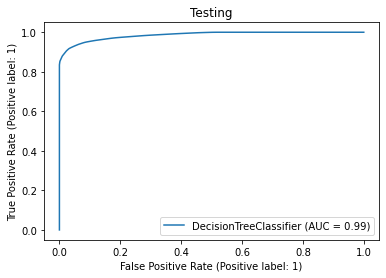

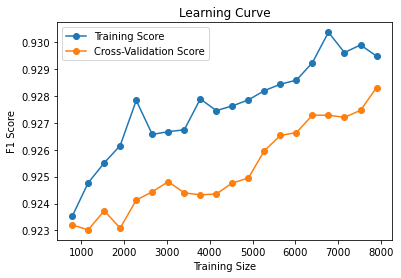

KNN traning time: 0.04812288284301758
KNN testing time: 2.9975929260253906
KNN F1: 0.9264010803511141
KNN Accuracy: 0.8673965936739659


In [52]:
KNN = KNeighborsClassifier(n_neighbors=k, n_jobs=-1) 

train_time, pred_time, f1, accuracy, bias_error, variance_error= Evaluation_basic(KNN,X_train, X_test, y_train, y_test)
Visualize_LC(KNN, X_train, y_train)

print("KNN traning time:", train_time)
print("KNN testing time:",pred_time)
print("KNN F1:",f1)
print("KNN Accuracy:",accuracy)

f1scores.append(('KNN', f1))
accuracies.append(('KNN', accuracy))
Train_times.append(('KNN',train_time))
Test_times.append(('KNN',pred_time))
bias_errors.append(('KNN', bias_error))
variance_errors.append(('KNN', variance_error))

# Comparison

In [58]:
df1 = pd.DataFrame(f1scores,columns = ['Model','f1'])
df2 = pd.DataFrame(accuracies,columns = ['Model','acc'])
df3 = pd.DataFrame(Train_times,columns = ['Model','time_train'])
df4 = pd.DataFrame(Test_times,columns = ['Model','time_test'])
df5 = pd.DataFrame(bias_errors,columns = ['Model','Error'])

models = pd.merge(pd.merge(pd.merge(pd.merge(df1,df2,on='Model'),df3,on='Model'),df4,on='Model'),df5,on='Model')
models

,Model,f1,acc,time_train,time_test,Error
0,DT,0.931010,0.879562,0.198677,0.059845,0.293377
1,NN,0.932106,0.880373,10.078095,0.009782,0.315086
2,Boost,0.933179,0.882806,3.651199,0.160590,0.298486
3,SVM,0.930739,0.878751,5.013474,1.571958,0.302024
4,KNN,0.926401,0.867397,0.048123,2.997593,0.398558


<Figure size 576x576 with 0 Axes>

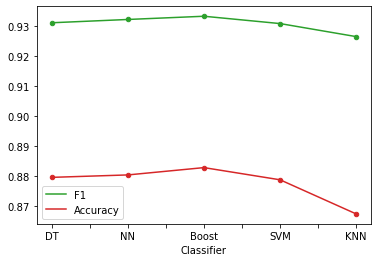

<Figure size 576x576 with 0 Axes>

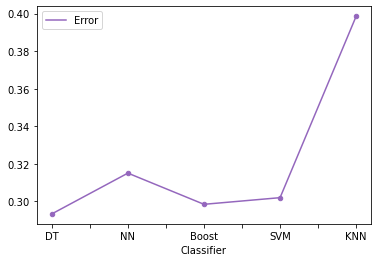

In [86]:
fig = plt.figure(figsize=(8,8))
fig.suptitle('Comparision - Scores')
ax = models.plot(x ="Model", y="f1", kind = "line", label = "F1", color="C2")
models.plot(x ="Model", y="f1", kind = "scatter", ax = ax, color="C2")
models.plot(x ="Model", y="acc", ax = ax, kind = "line", label = "Accuracy",color="C3")
models.plot(x ="Model", y="acc", ax = ax, kind = "scatter", color="C3")

plt.xlabel('Classifier')
plt.ylabel("")
plt.legend(loc="best")
plt.savefig('./Compare.png')
plt.show()



fig = plt.figure(figsize=(8,8))
fig.suptitle('Comparision - Error')
ax = models.plot(x ="Model", y="Error", kind = "line", label = "Error",color="C4")
models.plot(x ="Model", y="Error", ax = ax,kind = "scatter", color="C4")
plt.xlabel('Classifier')
plt.ylabel("")
plt.legend(loc="best")
plt.savefig('./Compare_error.png')
plt.show()


fig = plt.figure(figsize=(8,8))
fig.suptitle('Comparision - Time')
ax = models.plot(x ="Model", y="time_train", kind = "line", label = "Error",color="C5")
models.plot(x ="Model", y="time_train", ax = ax,kind = "scatter", color="C5")
plt.xlabel('Classifier')
plt.ylabel("")
plt.legend(loc="best")
plt.savefig('./Compare_time.png')
plt.show()